# Setup

In [6]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import scipy
import scipy.io
import pandas as pd

# filesystem and OS
import sys, os, time
import glob

# images
import skimage
import skimage
import skimage.io

# plotting
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from IPython import parallel

rc = parallel.Client()
all_engines = rc[:]
lbv = rc.load_balanced_view()

print len(all_engines)

40


# Define city growth model

In [19]:
import numpy as np

def generate_growth_map(N, nseeds=1, niter=3, gamma=1, target_p = None):
    # initialize board
    W_init = np.zeros((N,N))
    locations = np.array([(j,k) for j in range(N) for k in range(N)])
    
    if nseeds == 1:
        W_init[N/2,N/2] = 1
    else:
        seeds = locations[np.random.choice(range(len(locations)), size=nseeds)]
        for (j,k) in seeds:
            W_init[j,k] = 1

    C = [np.sqrt(x*x + y*y) for x in range(N-1) for y in range(N-1)]
    C = sum([x**(-gamma) for x in C if x>0])

    # propagate growth
    w = W_init.reshape((N*N))
    q0 = np.zeros(N*N)
    for i in range(niter):
        q = q0 * 0
        kvec = np.where(w>0)[0]
        locs = locations[kvec]
        wkdj = np.array([np.sqrt(((locations - loc_k)**2).sum(1))**(-gamma) \
                         for loc_k in locs])
        wkdj[np.isinf(wkdj)] = 0
        wdj = wkdj.sum(0)
        q = wdj / C
        q = q / q.max()
        w = np.random.random(N*N)<q
        if target_p:
            p = w.sum() / float(N**2)
            w = np.random.random(N*N)<q
            print p
            if p > target_p:
                break
        del wkdj, wdj, locs, q, kvec
    
    W = w.astype(int).reshape((N,N))
    return W, W_init, q.reshape((N,N))

0.0025
0.0097
0.0352
0.0874
0.1636
0.2648
0.355


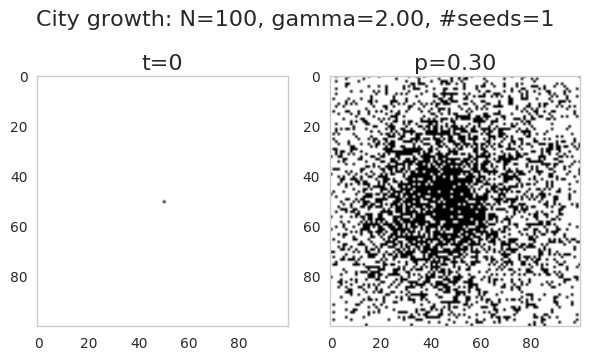

In [21]:
N = 100
nseeds = 1
niter = 100
gamma = 2
target_p = 0.3

W, W_init, Q = generate_growth_map(N, nseeds=nseeds, niter=niter, gamma=gamma, target_p=target_p)

# plot 
fig, ax = plt.subplots(1,2)
ax[0].imshow(W_init)
ax[0].set_title("t=0", fontsize=16)
ax[1].imshow(W)
ax[1].set_title("p=%2.2f"%target_p, fontsize=16)
plt.suptitle("City growth: N=%d, gamma=%2.2f, #seeds=%d"%(N, gamma, nseeds),\
            fontsize=16)
plt.tight_layout()

In [14]:
def f():
    return generate_growth_map(N, nseeds=nseeds, niter=niter, gamma=gamma, target_p=target_p)

In [15]:
from memory_profiler import memory_usage

mem_usage = memory_usage(f)
print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
print('Maximum memory usage: %s' % max(mem_usage))

Memory usage (in chunks of .1 seconds): [194.18359375, 132.21875, 133.37890625, 133.22265625, 141.84765625, 150.578125, 152.87109375, 152.87109375, 152.87109375, 160.3125, 169.32421875, 177.5625, 187.0859375, 196.109375, 204.875, 213.88671875, 222.90234375, 231.6640625, 240.6875, 249.70703125, 259.24609375, 268.01171875, 413.1796875, 145.3203125, 145.3203125, 152.1328125, 160.890625, 170.4140625, 179.4375, 188.453125, 197.4765625, 206.2421875, 215.265625, 224.03125, 233.0546875, 242.078125, 250.84375, 259.75, 268.7734375, 278.296875, 287.3203125, 296.33984375, 305.0859375, 314.10546875, 323.12890625, 332.66015625, 341.671875, 350.4140625, 359.4296875, 368.4375, 377.96484375, 386.984375, 395.7421875, 404.7578125, 413.76953125, 422.52734375, 431.53515625, 440.55078125, 449.3046875, 458.3203125, 467.8515625, 476.8671875, 485.87109375, 494.62890625, 503.6484375, 513.17578125, 522.19140625, 531.2109375, 539.96875, 548.98046875, 558.51953125, 567.54296875, 576.30078125, 585.30859375, 594.328

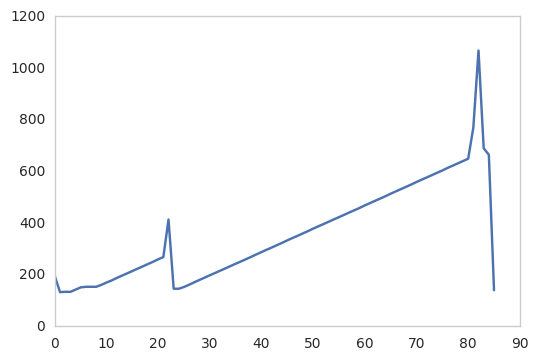

In [17]:
plt.plot(mem_usage)

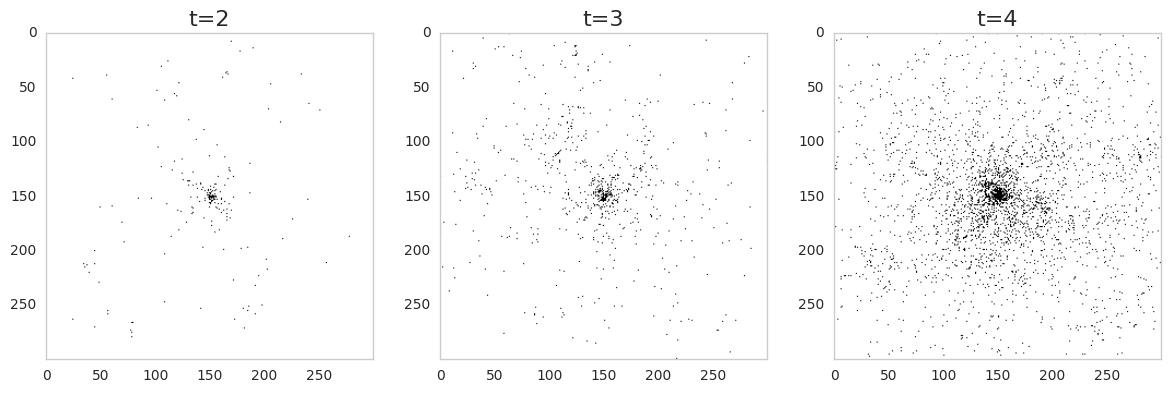

In [6]:
# plot 
fig, ax = plt.subplots(1,3, figsize=(12,4))

t = 2
W, _, _ = generate_growth_map(N, nseeds=nseeds, niter=t, gamma=gamma)
ax[0].imshow(W)
ax[0].set_title("t=%d"%t, fontsize=16)

t = 3
W, _, _ = generate_growth_map(N, nseeds=nseeds, niter=t, gamma=gamma)
ax[1].imshow(W)
ax[1].set_title("t=%d"%t, fontsize=16)

t = 4
W, _, _ = generate_growth_map(N, nseeds=nseeds, niter=t, gamma=gamma)
ax[2].imshow(W)
ax[2].set_title("t=%d"%t, fontsize=16)

plt.tight_layout()

# Generate samples 

In [7]:
gamma_vec = [2, 2.5, 3]
p_vec     = [0.05, 0.10, 0.15]

# gamma_vec = np.arange(1.5, 5, 0.25)
# p_vec     = np.arange(0.1, 0.5, 0.05)
    
N         = 300
N_vec     = [N]
N_PARAMS  = 4
nseed_vec = [1]

rand_seed = np.random.

params_vec = np.array(np.meshgrid(N_vec, gamma_vec, p_vec, nseed_vec))\
                .T.reshape((-1,N_PARAMS))

print "Generating %d configurations of %d parameters."%params_vec.shape

savepath = "/home/adalbert/data/city-growth/city-growth-medium/%d/train/"%N
n_samples = 1000 # number of samples per each parameter configuration

params_vec_run = np.tile(params_vec, n_samples).reshape((n_samples*len(params_vec), N_PARAMS))
params_vec_run = np.hstack([params_vec_run, np.arange(len(params_vec_run)).reshape(len(params_vec_run),1)])
np.random.shuffle(params_vec_run)

Generating 9 configurations of 4 parameters.


In [18]:
%%px

import os
import skimage
import skimage.io
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import skimage
import skimage.io

def generate_growth_map(N, nseeds=1, niter=3, gamma=1, target_p = None):
    # initialize board
    W_init = np.zeros((N,N))
    locations = np.array([(j,k) for j in range(N) for k in range(N)])
    
    if nseeds == 1:
        W_init[N/2,N/2] = 1
    else:
        seeds = locations[np.random.choice(range(len(locations)), size=nseeds)]
        for (j,k) in seeds:
            W_init[j,k] = 1

    C = [np.sqrt(x*x + y*y) for x in range(N-1) for y in range(N-1)]
    C = sum([x**(-gamma) for x in C if x>0])

    # propagate growth
    w = W_init.reshape((N*N))
    q0 = np.zeros(N*N)
    for i in range(niter):
        q = q0 * 0
        kvec = np.where(w>0)[0]
        locs = locations[kvec]
        wkdj = np.array([np.sqrt(((locations - loc_k)**2).sum(1))**(-gamma) \
                         for loc_k in locs])
        wkdj[np.isinf(wkdj)] = 0
        wdj = wkdj.sum(0)
        q = wdj / C
        q = q / q.max()
        w = np.random.random(N*N)<q
        if target_p:
            p = w.sum() / float(N**2)
            w = np.random.random(N*N)<q
            if p > target_p:
                break
        del wkdj, wdj, locs, q, kvec
    
    W = w.astype(int).reshape((N,N))
    return W, W_init, q.reshape((N,N))

In [13]:
def generate_map_config_fn(params, savepath=savepath):
    N, gamma, target_p, nseed, n = params
    N, nseed = int(N), int(nseed)
    max_niter = 100
    
    basedir = savepath + \
        "/N%d_gamma%2.2f_p%2.2f_nseed%d"%(N, gamma, target_p, nseed )
    if not os.path.exists(basedir):
        os.makedirs(basedir)

    W, W_init, Q = generate_growth_map(N, nseeds=nseed, niter=max_niter, gamma=gamma, target_p=target_p)
    filename = "%s/%d.png"%(basedir,n)
    filename = "%s/%d.png"%(basedir,n)
    skimage.io.imsave(filename, W)
    
    del W, W_init, Q
    
        
    return filename

In [14]:
amr = lbv.map_async(generate_map_config_fn, params_vec_run)

In [18]:
amr.completed

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 datetime.datetime(2017, 1, 26, 19, 36, 3, 529496, tzinfo=tzlocal()),
 None,
 None,
 None,
 None,
 datetime.datetime(2017, 1, 26, 19, 35, 59, 703575, tzinfo=tzlocal()),
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None

In [19]:
amr.progress

4

In [ ]:
amr.display_outputs()